1. Обработка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
def print_about(data_set):
    print('SHAPE\n', data_set.shape)
    print('\nINFO\n', data_set.info())
    print('\nHEAD\n', data_set.head(1).T)
    print('\nDESC\n', data_set.describe().T)

In [3]:
df_train = pd.read_csv('train.csv')
#print_about(df_train)

In [4]:
def print_objects(df):
    for i in df.columns:
        if str(df[i].dtype) == 'object':
            print('='*10)
            print(i)
            print(df[i].value_counts()) 
            print('\n')

In [5]:
#print_objects(df_train)

In [6]:
def preproc_data(df_input):
    df_output = df_input.copy()
        
    #Удаляю default т.к. неинформативные данные
    df_output = df_output.drop(['default'], axis=1)

    #Удаляем строки с пустыми данными
    #df_output = df_output[~(df_output['job'] == 'unknown')]
    #df_output = df_output[~(df_output['marital'] == 'unknown')]
    #df_output = df_output[~(df_output['education'] == 'unknown')]
    #df_output = df_output[~(df_output['housing'] == 'unknown')]
    #df_output = df_output[~(df_output['loan'] == 'unknown')]
    
    #Замена категориальных признаков
    #df_output.loc[:,  ['housing', 'loan']] = df_output.loc[:,  ['housing', 'loan']].replace({'no': 0, 'yes': 1})
    df_output = pd.get_dummies(df_output, columns=['housing', 'loan'])

    #Кодируем категориальные признаки
    df_output = pd.get_dummies(df_output, columns=['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome'])
    
    return df_output

In [7]:
df_train_preproc = df_train.pipe(preproc_data)

y = df_train_preproc['target']
X = df_train_preproc.drop(['_id', 'target'], axis=1)

print('X.shape', X.shape)
print('Y.shape', y.shape)

X.shape (24712, 60)
Y.shape (24712,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

2. КНН

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [10]:
model_KNN = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

model_KNN.fit(X_train, y_train)

predict_KNN = model_KNN.predict(X_test)
predict_proba_KNN = model_KNN.predict_proba(X_test)

3.1 Дерево принятия решения (Кросс валидация по однром гипер параметру)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, validation_curve

Text(0,0.5,'ROC AUC')

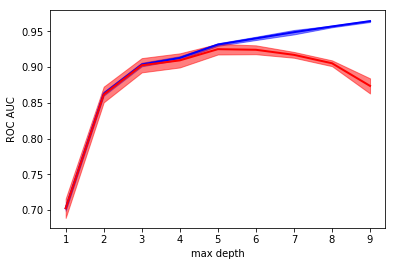

In [12]:
model_DTC = DecisionTreeClassifier(random_state=123)

model_DTC.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

train_scores, valid_scores = validation_curve(model_DTC, X, y, 'max_depth', range(1, 10), cv=cv, scoring='roc_auc')

train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2)
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

In [13]:
max_depth = 5
model_DTC = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=123)
model_DTC.fit(X_train, y_train)

predict_DTC = model_DTC.predict(X_test)
predict_proba_DTC = model_DTC.predict_proba(X_test)

3.2 Дерево принятия решения Random Search (Подбор всех гирперпараметров)

In [14]:
from scipy.stats import randint as randint
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [15]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 8),
    'min_samples_leaf': randint(5, 10),
    'class_weight': [None, 'balanced']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)

random_search.fit(X, y)

print('best_params', random_search.best_params_)
print('best_score', random_search.best_score_)

model_DTC_Rand = random_search.best_estimator_

predict_DTC_Rand = model_DTC_Rand.predict(X_test)
predict_proba_DTC_Rand = model_DTC_Rand.predict_proba(X_test)

best_params {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 7}
best_score 0.937119828479246


4. Логистическая регрессия

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
predict_LR = model_LR.predict(X_test)
predict_proba_LR = model_LR.predict_proba(X_test)

5. Сравнение результатов алгоритмов

In [18]:
print('KNeighborsClassifier\n')
print(classification_report(y_test, predict_KNN))

print('DecisionTreeClassifier\n')
print(classification_report(y_test, predict_DTC))

print('DecisionTreeClassifier (Random Search)\n')
print(classification_report(y_test, predict_DTC_Rand))

print('LogisticRegression\n')
print(classification_report(y_test, predict_LR))

KNeighborsClassifier

             precision    recall  f1-score   support

          0       0.91      0.97      0.94      6574
          1       0.54      0.29      0.38       840

avg / total       0.87      0.89      0.88      7414

DecisionTreeClassifier

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      6574
          1       0.69      0.45      0.54       840

avg / total       0.90      0.91      0.91      7414

DecisionTreeClassifier (Random Search)

             precision    recall  f1-score   support

          0       0.99      0.83      0.90      6574
          1       0.42      0.93      0.58       840

avg / total       0.92      0.84      0.87      7414

LogisticRegression

             precision    recall  f1-score   support

          0       0.93      0.98      0.95      6574
          1       0.70      0.38      0.49       840

avg / total       0.90      0.91      0.90      7414



ROC_AUC
KNeighborsClassifier			 0.7537220942529735
DecisionTreeClassifier			 0.9194480058527822
DecisionTreeClassifier (Random Search)	 0.9478228627928201
LogisticRegression			 0.9296146797629913


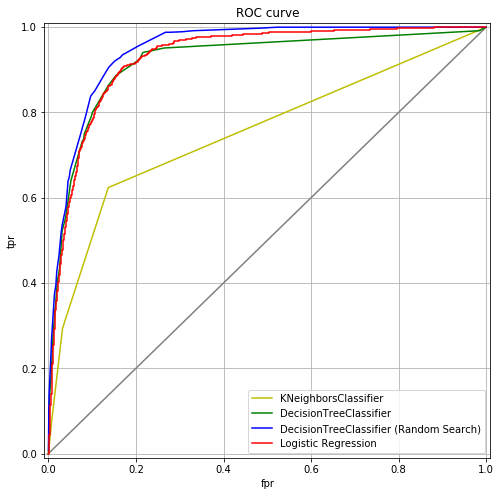

In [19]:
#ROC_AUC
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'grey')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

fpr_KNN, tpr_KNN, thresholds = roc_curve(y_test, predict_proba_KNN[:,1])
lineDTC = plt.plot(fpr_KNN, tpr_KNN, 'y-' ,label='KNeighborsClassifier')

fpr_DTC, tpr_DTC, thresholds = roc_curve(y_test, predict_proba_DTC[:,1])
lineDTC = plt.plot(fpr_DTC, tpr_DTC, 'g-' ,label='DecisionTreeClassifier')

fpr_DTC_R, tpr_DTC_R, thresholds = roc_curve(y_test, predict_proba_DTC_Rand[:,1])
lineDTC = plt.plot(fpr_DTC_R, tpr_DTC_R, 'b-' ,label='DecisionTreeClassifier (Random Search)')

fprLR, tprLR, thresholds = roc_curve(y_test, predict_proba_LR[:,1])
plt.plot(fprLR, tprLR, 'r-', label='Logistic Regression')

plt.legend()

roc_auc_KNN = roc_auc_score(y_test, predict_proba_KNN[:,1])
roc_auc_DTC= roc_auc_score(y_test, predict_proba_DTC[:,1])
roc_auc_DTC_Rand= roc_auc_score(y_test, predict_proba_DTC_Rand[:,1])
roc_auc_LR = roc_auc_score(y_test, predict_proba_LR[:,1])

print('ROC_AUC')
print('KNeighborsClassifier\t\t\t', roc_auc_KNN)
print('DecisionTreeClassifier\t\t\t', roc_auc_DTC)
print('DecisionTreeClassifier (Random Search)\t', roc_auc_DTC_Rand)
print('LogisticRegression\t\t\t', roc_auc_LR)

In [20]:
from sklearn.cross_validation import cross_val_score

cvs_KNN = cross_val_score(model_KNN, X, y, scoring='roc_auc', cv=10)
cvs_DTC = cross_val_score(model_DTC, X, y, scoring='roc_auc', cv=10)
cvs_DTC_R = cross_val_score(model_DTC_Rand, X, y, scoring='roc_auc', cv=10)
cvs_LR = cross_val_score(model_LR, X, y, scoring='roc_auc', cv=10)

print('AVG_ROC_AUC')
print('KNeighborsClassifier\t\t\t', sum(cvs_KNN)/len(cvs_KNN))
print('DecisionTreeClassifier\t\t\t', sum(cvs_DTC)/len(cvs_DTC))
print('DecisionTreeClassifier (Random Search)\t', sum(cvs_DTC_R)/len(cvs_DTC_R))
print('Logistic Regression\t\t\t', sum(cvs_LR)/len(cvs_LR))

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


AVG_ROC_AUC
KNeighborsClassifier			 0.7553029490771225
DecisionTreeClassifier			 0.930427484091563
DecisionTreeClassifier (Random Search)	 0.937398038735418
Logistic Regression			 0.929694771715434


6. Получение результата по лучшему алгоритму

In [21]:
import numpy as np

In [22]:
df_test = pd.read_csv('test.csv')

df_test_preproc = df_test.pipe(preproc_data)
X_test = df_test_preproc.drop(['_id'], axis=1)

result_predict = model_DTC_Rand.predict(X_test)

In [23]:
a = np.array(result_predict)
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 12200, 1: 4276}

In [24]:
#Формируем результат
df_test_preproc['target'] = result_predict

df_result = pd.merge(df_test, df_test_preproc, on='_id', how='outer')
#df_result.loc[df_result['target'].isnull(), 'target'] = 0 # Добавляем удаленные строки 0
df_result = df_result[['_id', 'target']].copy()

df_result['target'].value_counts()

0    12200
1     4276
Name: target, dtype: int64

In [25]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16476 entries, 0 to 16475
Data columns (total 2 columns):
_id       16476 non-null object
target    16476 non-null int64
dtypes: int64(1), object(1)
memory usage: 386.2+ KB


In [26]:
df_result.to_csv('result.csv', sep=',', encoding='utf-8', index=False)